<a href="https://colab.research.google.com/github/TobiBu/graddays/blob/main/day_2/notebooks/SBI_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation based inference tutorial


Thanks to Berkay Günes, we have this awesome tutorial on how to use SBI to perform inference on galactic parameters from the observation of chemical abundances of stars.

In [8]:
from urllib import request
import os

# create local folder
if os.path.isdir("./data") == False:
    os.mkdir("./data")

# get model weights
url = "https://heibox.uni-heidelberg.de/f/a7fbf75f5a314687af48/?dl=1"
target_path = "./data/pytorch_state_dict.pt"

# https://docs.python.org/3/library/urllib.request.html#urllib.request.Request
# NOTE: Transfer-Encoding: chunked (streaming) will be auto-selected
with request.urlopen(request.Request(url), timeout=15.0) as response:
    if response.status == 200:
        with open(target_path, "wb") as f:
            f.write(response.read())

In [1]:
!pip install sbi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [3]:
import numpy as np
from scipy.stats import norm

import sbi.utils as utils
from sbi.utils.user_input_checks import check_sbi_inputs, process_prior, process_simulator
from sbi.inference import NPE, simulate_for_sbi

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import time as t

In [4]:
# @title helper functions for plotting
#
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from scipy.stats import norm
from scipy.stats import multivariate_normal

##########################################################################################################
# --- Calculate mean and error ---
def mean_error(x, N_stars):
    mean = np.mean(x)
    std = np.std(x)
    err = std/np.sqrt(N_stars)

    return mean, err, std

##########################################################################################################
# --- Plot 1D Histogram ---
def plot_1d_hist(x1, x2, x_true, names, simulations):
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    plot_width = 0.3

    def plot_subplot(i, x, true, name):
        N_stars = int(len(x)/simulations)
        mean, err, std = mean_error(x, N_stars)

        # Set the x-axis limits
        x_min = true - plot_width*true
        x_max = true + plot_width*true

        # Fit a Gaussian to the data
        lin = np.linspace(x_min, x_max, 1000)
        p = norm.pdf(lin, mean, std)

        # Plot the data
        ax[i].hist(x, bins=500, density=True, alpha=0.6, color='g')
        ax[i].plot(lin, p, 'k', linewidth=2)
        ax[i].axvline(x=true, color='r', linestyle='dashed', linewidth=2)

        ax[i].set_title(fr"{name}: {true:.3f}"
                        "\n"
                        fr"Fit: {mean:.3f} $\pm$ {err:.3f}")
        ax[i].set_xlim(x_min, x_max)

    for i in [0,1]:
        if i == 0:
            x = x1
        else:
            x = x2

        plot_subplot(i, x, x_true[i], names[i])

    fig.suptitle(f'{int(len(x1)/simulations)} Stars', fontsize=30)
    plt.tight_layout()
    plt.show()

##########################################################################################################
# --- 2D Histogram preparation ---
def hist_2d_prep(x1, x2, x_true, N_stars):
    x_lim, y_lim = [-2.8,-1.8],[-3.4,-2.4]

    # --- Fit a 2D Gaussian to the data ---
    mean_1, err_1, std_1 = mean_error(x1, int(N_stars))
    mean_2, err_2, std_2 = mean_error(x2, int(N_stars))


    x = np.linspace(x_lim[0], x_lim[1], 1000)
    y = np.linspace(y_lim[0], y_lim[1], 1000)

    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))

    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    popt, pcov = multivariate_normal.fit(np.array([x1, x2]).T)
    rv = multivariate_normal(popt, pcov)


    # --- Calculate the sigma levels ---
    levels =[]
    sigma = [3,2,1]
    for n in sigma:
        level = rv.pdf(popt+n * np.array([std_1, std_2]))
        levels.append(level)

    return  x_lim, y_lim, X, Y, pos, rv, levels, sigma, mean_1, err_1, std_1, mean_2, err_2, std_2

##########################################################################################################
# --- Plot 2D Histogram ---
def plot_2d_hist(x1, x2, x_true, N_stars):
    x_lim, y_lim, X, Y, pos, rv, levels, sigma, mean_1, err_1, std_1, mean_2, err_2, std_2 = hist_2d_prep(x1, x2, x_true, N_stars)

    # labels
    label_gt = r'Ground Truth' + f"\n" + r"$\alpha_{\rm IMF} = $" + f'${round(x_true[0].item(), 2)}$' + f"\n" + r"$\log_{10} N_{\rm Ia} = $" + f'${round(x_true[1].item(), 2)}$'

    label_fit = r'Fit' + f"\n" + r"$\alpha_{\rm IMF} = $" + f'${round(mean_1.item(), 3)} \\pm {round(err_1.item(),3)}$' + f"\n" + r"$\log_{10} N_{\rm Ia} = $" + f'${round(mean_2.item(), 3)} \\pm {round(err_2.item(),3)}$'


    # --- Plot the data ---
    plt.figure(figsize=(15,15))
    plt.hist2d(x1, x2, bins=500, range=[x_lim, y_lim])

    # draw contour lines on1,2,3 sigma
    CS = plt.contour(X, Y, rv.pdf(pos), levels=levels, colors='k', linestyles='dashed')
    text = plt.clabel(CS, inline=True, fontsize=10)
    for i in range(len(sigma)):
        text[i].set(text=f'{sigma[i]} $\\sigma$')

    legend_true = plt.scatter(x_true[0], x_true[1], color='r', s=10, label=label_gt)
    legend_fit = plt.errorbar(mean_1, mean_2, yerr=err_2, xerr=err_1, color='k', marker='.', label=label_fit)

    legend_fit = plt.legend(handles=[legend_fit], fontsize=15, shadow=True, fancybox=True, loc=2, bbox_to_anchor=(0, 0.9))
    legend_true = plt.legend(handles=[legend_true], fontsize=15, shadow=True, fancybox=True, loc=2, bbox_to_anchor=(0, 0.99))

    plt.gca().add_artist(legend_fit)
    plt.gca().add_artist(legend_true)

    plt.xlabel(r'$\alpha_{\rm IMF}$', fontsize=20)
    plt.ylabel(r'$\log_{10} N_{\rm Ia}$', fontsize=20)
    #plt.legend(fontsize=15, shadow=True, fancybox=True, loc=2,)
    plt.show()

##########################################################################################################
# --- Plot 2D Histogram with side plots ---
def plot_2d_hist_sides(x1, x2, x_true, N_stars):
    x_lim, y_lim, X, Y, pos, rv, levels, sigma, mean_1, err_1, std_1, mean_2, err_2, std_2 = hist_2d_prep(x1, x2, x_true, N_stars)

    x = np.linspace(x_lim[0], x_lim[1], 1000)
    y = np.linspace(y_lim[0], y_lim[1], 1000)

    # --- Plot the data ---
    fig = plt.figure(1, figsize=(15,15))


    # Define the locations for the axes
    left, width = 0.12, 0.7
    bottom, height = 0.12, 0.7
    bottom_h = left_h = left+width+0.02

    # Set up the geometry of the three plots
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.15] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.15, height] # dimensions of y-histogram

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram

    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    axHistx.axis('off')
    axHisty.axis('off')


    # Plot the data
    axTemperature.hist2d(x1, x2, bins=500, range=[x_lim, y_lim])

    # draw contour lines on sigma levels
    CS = axTemperature.contour(X, Y, rv.pdf(pos), levels=levels, colors='k', linestyles='dashed')
    text = axTemperature.clabel(CS, inline=True, fontsize=15)
    for i in range(len(sigma)):
        text[i].set(text=f'{sigma[i]} $\\sigma$')

    # labels
    label_gt = r'Ground Truth' + f"\n" + r"$\alpha_{\rm IMF} = $" + f'${round(x_true[0].item(), 2)}$' + f"\n" + r"$\log_{10} N_{\rm Ia} = $" + f'${round(x_true[1].item(), 2)}$'

    label_fit = r'Fit' + f"\n" + r"$\alpha_{\rm IMF} = $" + f'${round(mean_1.item(), 3)} \\pm {round(err_1.item(),3)}$' + f"\n" + r"$\log_{10} N_{\rm Ia} = $" + f'${round(mean_2.item(), 3)} \\pm {round(err_2.item(),3)}$'

    # plot the ground truth and the fit
    legend_true = axTemperature.scatter(x_true[0], x_true[1], color='r', label=label_gt, s=10)
    legend_fit = axTemperature.errorbar(mean_1, mean_2, yerr=err_2, xerr=err_1, color='k', marker='.', label=label_fit)

    axTemperature.set_xlabel(r'$\alpha_{\rm IMF}$', fontsize=40)
    axTemperature.set_ylabel(r'$\log_{10} N_{\rm Ia}$', fontsize=40)
    axTemperature.tick_params(labelsize=30)

    # plot the histograms
    axHistx.hist(x1, bins=500, density=True, alpha=0.6, color='g')
    axHisty.hist(x2, bins=500, density=True, alpha=0.6, color='g', orientation='horizontal')

    axHistx.plot(x, norm.pdf(x, mean_1, std_1), 'k', linewidth=2)
    axHisty.plot(norm.pdf(y, mean_2, std_2), y, 'k', linewidth=2)

    axHistx.axvline(x=x_true[0], color='r', linestyle='dashed', linewidth=2)
    axHisty.axhline(y=x_true[1], color='r', linestyle='dashed', linewidth=2)

    axHistx.set_xlim(x_lim)
    axHisty.set_ylim(y_lim)

    fig.legend(handles=[legend_true], fontsize=25, shadow=True, fancybox=True, loc=2)#, bbox_to_anchor=(0.05, 0.92))
    fig.legend(handles=[legend_fit], fontsize=25, shadow=True, fancybox=True, loc=1)#, bbox_to_anchor=(0.05, 0.99))

    plt.show()

##########################################################################################################
# --- N-Star parameter plot ---
def n_stars_plot(x1, x2, x_true, no_stars= np.array([1, 10, 100, 500, 1000]), simulations=1000):
    fit = []
    err = []

    # --- Fit a 2D Gaussian to the data ---
    for n in no_stars:
        samples = int(n*simulations)
        N_stars = int(samples/simulations)
        mean_1, err_1, _ = mean_error(x1[0:samples], N_stars)
        mean_2, err_2, _ = mean_error(x2[0:samples], N_stars)

        fit.append([mean_1, mean_2])
        err.append([err_1, err_2])


    fit = np.array(fit)
    err = np.array(err)

    # --- Plot the data ---
    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(26,6))

    def plot(fit, err, x_true, ax, name):
        ax.plot(no_stars, fit, color="b", label="Fit")
        ax.fill_between(no_stars, fit-err, fit+err, alpha=0.3,color="b", label=r"1 & 2 $\sigma$")
        ax.fill_between(no_stars, fit-2*err, fit+2*err, alpha=0.2,color="b")

        ax.axhline(x_true, color='k', linestyle=':', linewidth=2, label='Ground Truth')

        ax.set_xlabel(r'$N_{\rm stars}$', fontsize=20)
        ax.set_ylabel(name, fontsize=20)
        ax.set_ylim([x_true-0.1*abs(x_true), x_true+0.1*abs(x_true)])
        ax.set_xscale('log')
        ax.set_xlim([1,1000])

    for i, name in enumerate([r'$\alpha_{\rm IMF}$', r'$\log_{10} N_{\rm Ia}$']):
        plot(fit[:,i], err[:,i], x_true[i], ax[i], name)

    ax[0].legend(fontsize=15, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.show()

##########################################################################################################
# --- N-Star comparison plot ---

def n_stars_plot_comp(x1, x2, x_true, dat, no_stars= np.array([1, 10, 100, 500, 1000]), simulations=1000):
    fit = []
    err = []

    # Extract the lambda values and n-stars
    all_Lambdas = dat.f.Lambdas
    n_stars = dat.f.n_stars

    # Here we compute the statistical variances, averaged across realizations with the same value of n-stars
    med,lo,up,lo2,up2,sample_lo,sample_hi=[np.zeros((len(n_stars),2)) for _ in range(7)]
    for i in range(len(n_stars)):
        # Select only the Lambda estimates for this value of n-stars
        theseL=all_Lambdas[i]
        # Now compute the median, 1- and 2-sigma parameter ranges from the output chains for each realization using this n-stars.
        lowL2,lowL,medianL,upL,upL2 = [[np.percentile(L,p,axis=0) for L in theseL] for p in [2.275,15.865,50.,84.135,97.725]]
        # Take the average over all realizations
        up[i]=np.median(upL,axis=0)
        lo[i]=np.median(lowL,axis=0)
        up2[i]=np.median(upL2,axis=0)
        lo2[i]=np.median(lowL2,axis=0)
        med[i]=np.median(medianL,axis=0)

    # --- Fit a 2D Gaussian to the data ---
    for n in no_stars:
        samples = int(n*simulations)
        N_stars = int(samples/simulations)
        mean_1, err_1, _ = mean_error(x1[0:samples], N_stars)
        mean_2, err_2, _ = mean_error(x2[0:samples], N_stars)

        fit.append([mean_1, mean_2])
        err.append([err_1, err_2])


    fit = np.array(fit)
    err = np.array(err)

    # --- Plot the data ---
    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(26,6))

    def plot(fit, err, x_true, ax, name):
        ax.plot(no_stars, fit, color="b", label="Fit")
        ax.fill_between(no_stars, fit-err, fit+err, alpha=0.1,color="b", label=r"1 & 2 $\sigma$")
        ax.fill_between(no_stars, fit-2*err, fit+2*err, alpha=0.1,color="b")

        ax.axhline(x_true, color='k', linestyle=':', linewidth=2, label='Ground Truth')

        ax.set_xlabel(r'$N_{\rm stars}$', fontsize=40)
        ax.set_ylabel(name, fontsize=40)
        ax.set_ylim([x_true-0.2*abs(x_true), x_true+0.2*abs(x_true)])
        ax.set_xscale('log')
        ax.set_xlim([1,1000])
        ax.tick_params(labelsize=30, size=10, width=3)
        ax.tick_params(which='minor', size=5, width=2)
        # Add Philcox
        ax.plot(n_stars,med[:,i],c='r', label="HMC")
        ax.fill_between(n_stars,lo[:,i],up[:,i],alpha=0.2,color='r')
        ax.fill_between(n_stars,lo2[:,i],up2[:,i],alpha=0.1,color='r')

    for i, name in enumerate([r'$\alpha_{\rm IMF}$', r'$\log_{10} N_{\rm Ia}$']):
        plot(fit[:,i], err[:,i], x_true[i], ax[i], name)

    ax[0].legend(fontsize=20, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.show()

##########################################################################################################

# Inferring Galactic Parameters from Chemical Abundances with Simulation-Based Inference

# Priors

In [5]:
# Elements to track
labels_out = ['C', 'Fe', 'H', 'He', 'Mg', 'N', 'Ne', 'O', 'Si']

# Input parameters
labels_in = ['high_mass_slope', 'log10_N_0', 'log10_starformation_efficiency', 'log10_sfr_scale', 'outflow_feedback_fraction', 'time']
priors = torch.tensor([[-2.3000,  0.3000],
                       [-2.8900,  0.3000],
                       [-0.3000,  0.3000],
                       [ 0.5500,  0.1000],
                       [ 0.5000,  0.1000]])

combined_priors = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)


# Model

Simple Neural Network to replace the simulator and create training data.

In [6]:
class Model_Torch(torch.nn.Module):
    def __init__(self):
        super(Model_Torch, self).__init__()
        self.l1 = torch.nn.Linear(len(labels_in), 100)
        self.l2 = torch.nn.Linear(100, 40)
        self.l3 = torch.nn.Linear(40, len(labels_out))

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x

model = Model_Torch()

In [9]:
# --- Load the weights ---
model.load_state_dict(torch.load('data/pytorch_state_dict.pt'))
model.eval();

<ipython-input-9-4bc3fa3caa4c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('data/pytorch_state_dict.pt'))


# Train SBI

In [10]:
# ----- set up the simulator -----
def simulator(params):
    y = model(params)
    y = y.detach().numpy()

    # Remove H from data, because it is just used for normalization (output with index 2)
    y = np.delete(y, 2)

    return y

In [11]:
prior, num_parameters, prior_returns_numpy = process_prior(combined_priors)
simulator = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)

In [12]:
# ----- set up model -----
inference = NPE(prior=prior, show_progress_bars=True)

start = t.time()

# --- simulate the training data ---
print()
print("Simulating data...")
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=10000)
print(f"Genereted {len(theta)} samples")

# --- add noise ---
pc_ab = 5 # observational error in abundance

x_err = np.ones_like(x)*float(pc_ab)/100.
x = norm.rvs(loc=x,scale=x_err)
x = torch.tensor(x).float()

# --- train ---
print()
print("Training the posterior...")
density_estimator = inference.append_simulations(theta, x).train()

# --- build the posterior ---
posterior = inference.build_posterior(density_estimator)

end = t.time()
comp_time = end - start

print()
print(f'Time taken to train the posterior with {len(theta)} samples: '
      f'{np.floor(comp_time/60).astype("int")}min {np.floor(comp_time%60).astype("int")}s')


Simulating data...


  0%|          | 0/10000 [00:00<?, ?it/s]

Genereted 10000 samples

Training the posterior...
 Neural network successfully converged after 220 epochs.
Time taken to train the posterior with 10000 samples: 3min 20s


# Simulate observations
Simulate the chemical abundances for the sampled stars using the simulator.

In [13]:
# Global parameters of galaxy
# high_mass_slope and log10_N_0
globalP = torch.tensor([[-2.3, -2.89]])

# Local parameters
# log10_starformation_efficiency, log10_sfr_scale, outflow_feedback_fraction, time
# independet parameters for each star in the galaxy
localP = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors[2:]] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

In [14]:
N_stars = 1000
simulations = 1000

# Create N_stars individual stars for the galaxy
stars = localP.sample((N_stars,))
stars = torch.cat((globalP.repeat(N_stars, 1), stars), dim=1)

In [15]:
# ----- Simulate abundances -----
start = t.time()
abundances = model(stars)

# Remove H from data, because it is just used for normalization (output with index 2)
abundances = torch.cat([abundances[:,0:2], abundances[:,3:]], axis=1)
end = t.time()
print(f'Time to create data for {N_stars} stars: {end-start:.3f} s')

Time to create data for 1000 stars: 0.011 s


In [16]:
def add_noise(true_abundances):
    # Define observational erorrs
    pc_ab = 5 # percentage error in abundance

    # Jitter true abundances and birth-times by these errors to create mock observational values.
    obs_ab_errors = np.ones_like(true_abundances)*float(pc_ab)/100.
    obs_abundances = norm.rvs(loc=true_abundances,scale=obs_ab_errors)

    return obs_abundances

# Inference
Use the mock observations to infer the Galactic parameters.

In [17]:
alpha_IMF_obs = []
log10_N_Ia_obs = []
simulations = 100

start = t.time()
for i in range(len(abundances)):
    x = add_noise(abundances[i].detach().numpy())
    alpha, N_Ia = posterior.sample((simulations,), x=x, show_progress_bars=False)[:,0:2].T
    alpha_IMF_obs.append(alpha)
    log10_N_Ia_obs.append(N_Ia)
end = t.time()
print(f'Time to run {simulations} simulations for {N_stars} stars: {end-start:.3f} s')

alpha_IMF_obs = np.array(alpha_IMF_obs).ravel()
log10_N_Ia_obs = np.array(log10_N_Ia_obs).ravel()

Time to run 100 simulations for 1000 stars: 31.357 s


# Plot

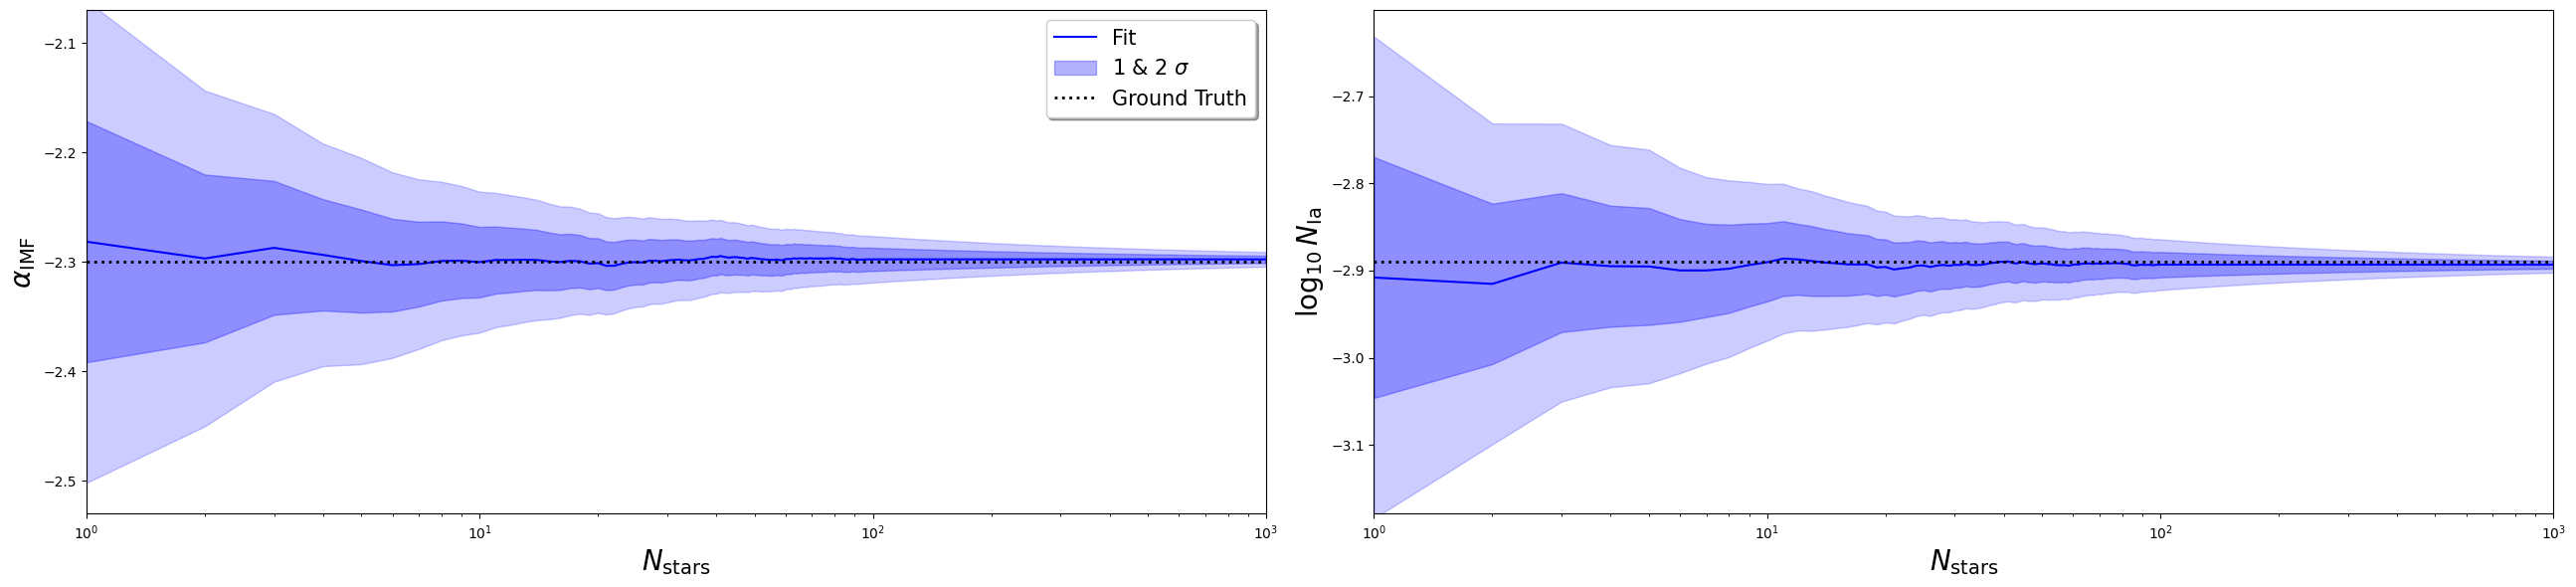

In [18]:
stars = np.arange(1,1000)
n_stars_plot(alpha_IMF_obs, log10_N_Ia_obs, globalP[0], stars)

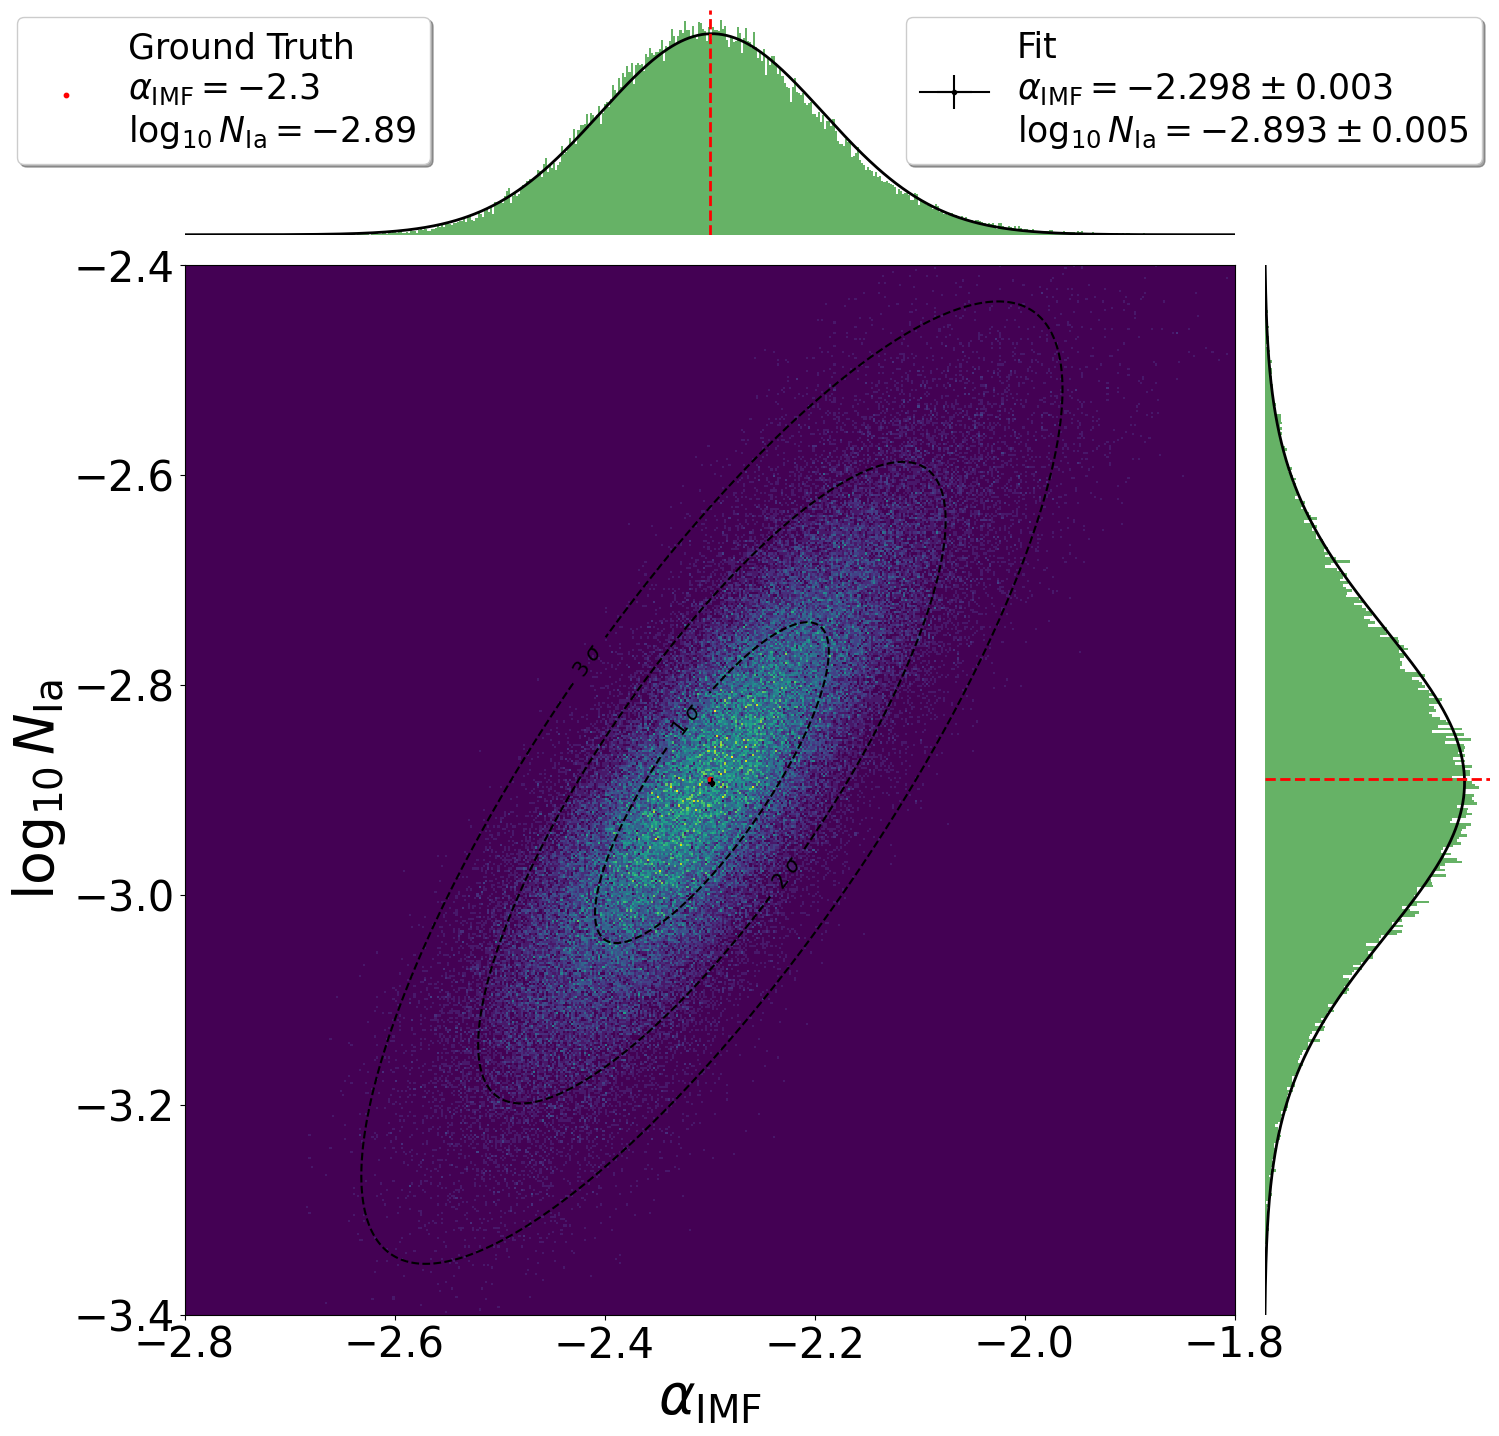

In [19]:
plot_2d_hist_sides(alpha_IMF_obs, log10_N_Ia_obs, globalP[0], N_stars)